<img src="../../images/QISKit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Visualizing a Quantum Data and States*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Jay Gambetta and Andrew Cross

In [1]:
import sys, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please enter your token: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found on Python path; Qconfig loaded from user input.')

Please enter your token: ········
Qconfig.py not found on Python path; Qconfig loaded from user input.


In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pprint import pprint
from scipy import linalg as la

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, execute, register, get_backend

# import state tomography functions
from qiskit.tools.visualization import plot_histogram, plot_state

In [4]:
def ghz_state(q, c, n):
    # Create a GHZ state
    qc = QuantumCircuit(q, c)
    qc.h(q[0])
    for i in range(n-1):
        qc.cx(q[i], q[i+1])
    return qc

def superposition_state(q, c):
    # Create a Superposition state
    qc = QuantumCircuit(q, c)
    qc.h(q)
    return qc

### The outcomes of a quantum circuit 

In quantum physics you generally cannot measure a state without disturbing it. The act of measurement changes the state. After performing a quantum measurement, a qubit's quantum information reduces to a classical bit. In our system, as is standard, measurements are performed in the computational basis. For each qubit, the measurement either results in the value 0 if the qubit is measured in state $\left| 0\right\rangle$, or in the value 1 if the qubit is measured in state $\left| 1\right\rangle$. 

In a given run of a quantum circuit that concludes with measurements of all $n$ qubits, the result will be one of the  possible $n$-bit binary strings. If the experiment is run a second time, even if the measurement is perfect and has no error, the outcome may be different due to the fundamental randomness of quantum physics. The measurement results from many executions of the quantum circuit can be represented as a probability distribution over the possible outcomes. For a quantum circuit which has previously run on a backend with name `circuit`, a histogram visualizing the probability distribution can be obtained provided you have imported ```tools.visualization```. The histogram is generated by

```
plot_histogram(result.get_counts('circuit'), number)
```

The generated bar graph is simple to understand. The height of each bar represents the fraction of instances the corresponding outcome is obtained within the total number of shots on the backend. Only those outcomes that occurred at least once are displayed. The optional parameter `number` specifies the total number of bars to be displayed. All remaining probability is collected into a single bar labeled "rest". Quantum circuits for most quantum algorithm will typically have one outcome (representing the desired solution to the problem), or at most a few outcomes. Only circuits that produce superpositions of many computational states as their final state will give many outcomes, and collecting those could require an exponentially large number of measurements. To demonstrate this, we study two circuits: a GHZ state and a superposition state involving 3 qubits. 

In [5]:
# Build the quantum cirucit. We are going to build two circuits a GHZ over 3 qubits and a
# superpositon over all 3 qubits 

n = 3  # number of qubits 
q = QuantumRegister(n)
c = ClassicalRegister(n)

# quantum circuit to make a GHZ state 
ghz = ghz_state(q, c, n)


# quantum circuit to make a superposition state 
superposition = superposition_state(q, c)

measure_circuit = QuantumCircuit(q,c)
measure_circuit.measure(q, c)

# execute the quantum circuit 
backend = 'local_qasm_simulator' # the device to run on
circuits = [ghz+measure_circuit, superposition+measure_circuit]
job = execute(circuits, backend=backend, shots=1000)

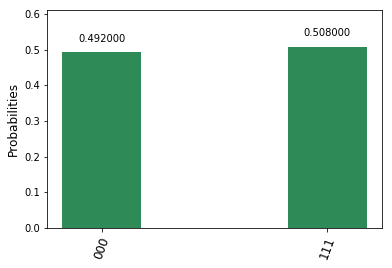

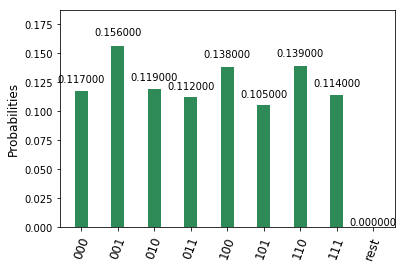

In [6]:
plot_histogram(job.result().get_counts(circuits[0]))
plot_histogram(job.result().get_counts(circuits[1]),15)

### Method for visualizing a quantum state

For educational and debugging purposes, it is useful to visualize the quantum state given by a density matrix $\rho$. This can not be obtained from a single shot of an experiment or simulation of quantum cirucit. However, in QISKit we have also provided a unitary simulator, which provided you dont place measurements these backends will return the quantum state.


In [7]:
n = 2  # number of qubits 
q = QuantumRegister(n)
c = ClassicalRegister(n)

qc = QuantumCircuit(q, c)
qc.h(q[1])


# execute the quantum circuit 
job = execute(qc, backend='local_statevector_simulator')
state_superposition = job.result().get_statevector(qc)
state_superposition

array([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j])

#### Pure states

A pure state $\left|\psi\right\rangle$ is an element of the Hilbert space $\mathcal{H}$. For $n$ qubits, the Hilbert space is the complex vector space $\mathbb{C}^{d}$ with dimension $d=2^n$. We denote the inner product between quantum states by $\left\langle \phi \right| \psi \rangle$. We denote the canonical set of orthonormal basis vectors spanning $\mathcal{H}$ as $\left| i\right\rangle$ where $i\in {0,...,d-1}$ and  $\left\langle j \right| i \rangle =\delta_{i,j}$. This allows us to define an arbitrary pure state, state vector, or ket as

$$\left|\psi\right\rangle = \sum_{i=0}^{d-1}\psi_i \left| i\right\rangle,$$

where the $\psi_i$ are complex numbers. The dual vector, or bra, is defined as

$$\left\langle\psi\right| = \sum_{i=0}^{d-1}\psi_i^* \left\langle i\right|.$$

With this, the inner product takes the form

$$\left\langle \phi \right| \psi \rangle  = \sum_{i=0}^{d-1} \phi^*_i \psi_i.$$

We require the state vector to be normalized, $\left\langle \psi \right| \psi \rangle = \sum_{i=0}^{d-1} |\psi_i|^2 =1$. As a result, $(d - 1)$ complex numbers are necessary to describe an arbitrary pure state.


In [8]:
def overlap(state1, state2):
    return round(np.dot(state1.conj(), state2))

In [9]:
print(state_superposition)

overlap(state_superposition, state_superposition)

[0.70710678+0.j 0.        +0.j 0.70710678+0.j 0.        +0.j]


(1+0j)

#### Operators

In order to relate the state to quantities of physical interest, we need to introduce operators. An operator is an object which maps a state from Hilbert space onto another state. Hence, in Dirac notation an operator can be written as

$$A = \sum_{i,j} a_{i,j} \left|i\right\rangle \left\langle j\right|$$ 

where $a_{ij}$ are complex numbers. For a given state $\left|\psi \right\rangle$, the mean or expectation value of $A$ is written as 

$$\langle A \rangle  = \left\langle \psi \right|A \left|\psi\right\rangle. $$ 



In [10]:
def expectation_value(state, Operator):
    return round(np.dot(state.conj(), np.dot(Operator, state)).real)

In [11]:
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
IZ = np.kron(np.eye(2), Z)
ZI = np.kron(Z, np.eye(2))
IX = np.kron(np.eye(2), X)
XI = np.kron(X, np.eye(2))


print("Operator Z on qubit 0 is " + str(expectation_value(state_superposition, IZ)))
print("Operator Z on qubit 1 is " + str(expectation_value(state_superposition, ZI)))
print("Operator X on qubit 0 is " + str(expectation_value(state_superposition, IX)))
print("Operator X on qubit 1 is " + str(expectation_value(state_superposition, XI)))

Operator Z on qubit 0 is 1.0
Operator Z on qubit 1 is 0.0
Operator X on qubit 0 is 0.0
Operator X on qubit 1 is 1.0



#### Mixed states

Consider the expectation value with respect to a statistical mixture of states 
$$\langle A \rangle  = \sum_k P_k \langle \psi_k |A |\psi_k\rangle = \mathrm{Tr}[A \rho ]. $$

Here,

$$\rho = \sum_k p_k |\psi_k\rangle\langle \psi_k |.$$

captures the most general type of quantum state known as a mixed state. $\rho$ is called the density matrix or state operator. A quantum state operator must obey the following three constraints:
1. Normalization, $\mathrm{Tr}(\rho) = 1$.
2. Hermiticity, $\rho^\dagger = \rho$.
3. Positive semi-definiteness, i.e. eigenvalues of $\rho$ must be non-negative.

The real and imaginary matrix elements $\rho_{i,j}$ represent the standard representation of a quantum state. QISKit provides the following function to plot them:

```
plot_state(rho, method="city")
```
This draws two 2-dimensional bargraphs (for the real and the imaginary part of $\rho$). Note that the diagonal is necessarily real and sums to 1 (due to normalization), and $\rho_{i,j} =\rho_{j,i}^*$ due to Hermiticity.

It can be useful to interpret operators as vectors in a complex space of dimensions $d^2$ ($\mathbb{C}^{d^2}$). To access the element $a_{ij}$, we use $a_p$ where $p = i + jd$. The indices $i$ and $j$ associated with a given $p$ are given by $i = p \% d$ and $j = \mathrm{floor}(p/d)$. We will use double-ket notation $\mid A \rangle$ to represent the matrix $A$ as a vector in the operator vector space. In this operator space, we also define an inner product in the standard way:

$$
\newcommand{\llangle}{\langle\!\langle}
\newcommand{\rrangle}{\rangle\!\rangle}
\llangle A \mid B\rrangle = \sum_{p=0}^{d^2-1}a^*_pb_p=\sum_{i,j=0}^{d-1} a_{ij}^* b_{ij}=\mathrm{Tr}[A^\dagger B].$$

Employing an orthonormal basis $\{\mid A_j \rrangle\}$ of the operator space, we can decompose $\rho$:

$$\mid \rho \rrangle = \sum_{j=0}^{d^2-1} \mid A_j\rrangle\llangle A_j\mid\rho\rrangle = \sum_{j=0}^{d^2-1} \rho_j \mid A_j\rrangle.$$  

(Here, some of the basis states may represent operators that are not measurable.) The Pauli basis, consisting of the $4^n$ operators formed by all tensor products of the Pauli operators ${I,X,Y,Z}$, provides a special basis in which $\rho$ has only real-valued coefficients $\rho_q$,

$$\mid \rho \rrangle = \frac{1}{d}\sum_{q=0}^{d^2-1} \rho_q \mid P_q\rrangle.  $$

To display a bar graph of these coefficients, QISKit provides the method 
```
plot_state(rho, method="paulivec"),
```

as well as the method 

```
plot_state(rho, method="qsphere")
```
which plots the "qspheres" of the quantum state as follows. Since $\rho$ is a hermitian operator, we can diagonalize it:  

$$\rho = \sum_k \lambda_k \left|\lambda_k\right\rangle\!\left\langle \lambda_k \right|.$$

For each eigenvalue $\lambda_k$, the corresponding pure state $\left|\lambda_k\right\rangle$ is plotted on a "qsphere". Each "qsphere" is divided into $n+1$ levels. Each such level is used to represent the weight (total number of 1s) of the binary outcome. The top level corresponds to the $\left|0\ldots0\right\rangle$ state, the next level includes all states with a single 1 ($\left|10\ldots0\right\rangle$, $\left|010\ldots0\right\rangle$, etc.), the level after that comprises all states with two 1s, and so on. Finally, the bottom level represents the state $\left|1\ldots1\right\rangle$. The contrast of each line is set to $\left|\langle i\mid\lambda\rangle\right|^2$, and the color represents the phase via the angle $\angle(\langle i\mid\lambda\rangle)$, with the global phase normalized to the maximum amplitude.

This visualization gives a useful and compact representation for quantum states that are close to pure states. 

As an example we consider the same states as above.

In [12]:
def state_2_rho(state):
    return np.outer(state, state.conj())

In [13]:
rho_superposition=state_2_rho(state_superposition)
print(rho_superposition)

[[0.5+0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]


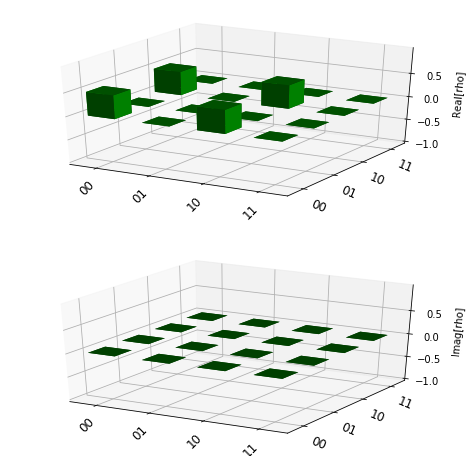

In [14]:
plot_state(rho_superposition,'city')

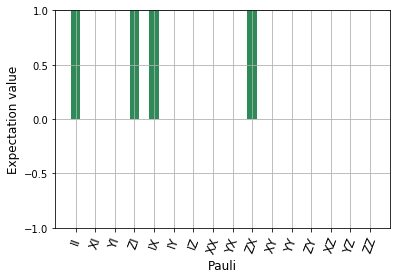

In [15]:
plot_state(rho_superposition,'paulivec')

The 0th eigenvalue = 1.0


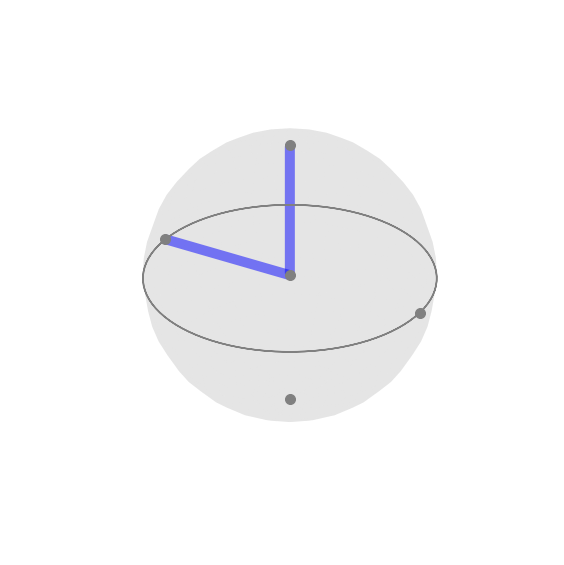

In [16]:
plot_state(rho_superposition,'qsphere')

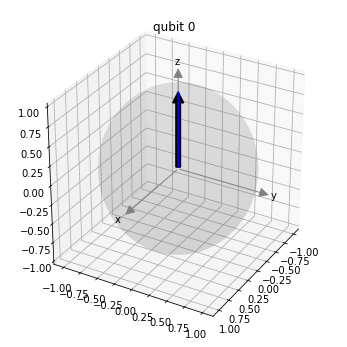

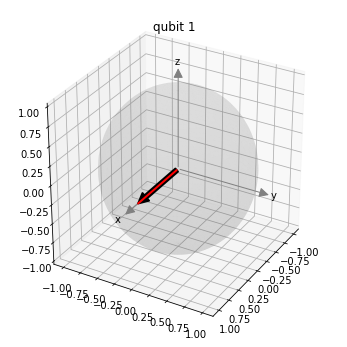

In [17]:
plot_state(rho_superposition,'bloch')

The 0th eigenvalue = 1.0


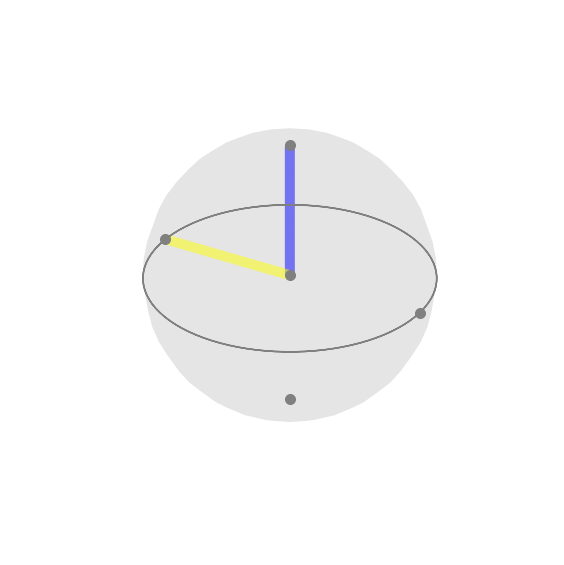

In [22]:
n = 2  # number of qubits 
q = QuantumRegister(n)
c = ClassicalRegister(n)

qc2 = QuantumCircuit(q, c)
qc2.h(q[1])
qc2.z(q[1])


# execute the quantum circuit 
job = execute(qc2, backend='local_statevector_simulator')
state_neg_superposition = job.result().get_statevector(qc2)
rho_neg_superposition=state_2_rho(state_neg_superposition)
plot_state(rho_neg_superposition, 'qsphere')

The 0th eigenvalue = 0.5000000000000001


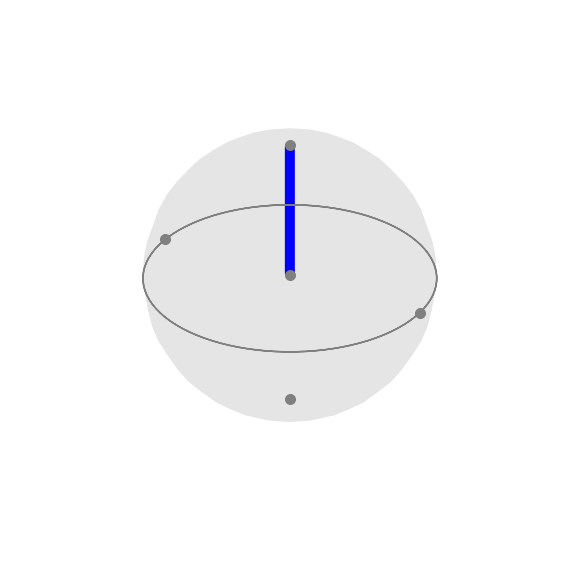

The 1th eigenvalue = 0.4999999999999999


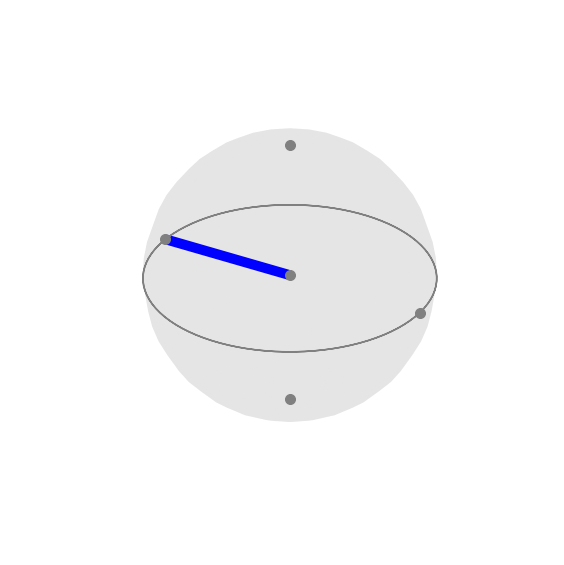

In [21]:
plot_state(0.5*rho_neg_superposition + 0.5* rho_superposition, 'qsphere')